---

# **Evaluate the the Bayesian network**

## **1. Description**

Here, I will test the predictive accuracy of the Bayesian Network using k-fold cross-validation.

Our objective will be to fit the model on each k fold, and perform validation procedures to assess the model's performance.

---

## **2. Prepare the session**

### **2.1 Load the libraries**

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt

from joblib import load

from sklearn.metrics import roc_auc_score, roc_curve, precision_recall_curve, auc
from sklearn.model_selection import KFold

from pgmpy.models import BayesianNetwork
from pgmpy.estimators import BayesianEstimator

### **2.2 Import the model data**

In [2]:
# Define the parent directory
parent_dir = os.path.abspath(
    os.path.join(os.getcwd(), os.pardir)
)

# Define the subfolder directory
output_folder = os.path.join(
    parent_dir, "outputs"
)

# Name of the model data output file
file_name1 = "BayesNet-model-data.joblib"

model_data = load(
    os.path.join(output_folder, file_name1)
)

---

## **3. Assess model performance**

### **3.1 AUC-ROC curve**

Here, we use the AUC-ROC curve to evaluate the predictive accuracy of the Bayesian network.

Using k-fold cross-validation, we can estimate and evaluate the variance in the ROC metric across different folds of the data.

This is how the accuracy is calculated : 

$
N. \ correct \ predictions = true \ positives + true \ negatives
$

$
N. \ all \ predictions = true \ positives + true \ negatives + false \ positives + false \ negatives
$

$
accuracy = \frac{N. \ correct \ predictions}{N. \ all \ predictions}
$

Explain the process of the function...

In [5]:
def k_fold_AUC_BN(model_data, n_splits = 5, random_state = 123):
    
    # Shuffle the predator IDs
    ids = model_data["predator_id"].unique()
    np.random.seed(random_state)
    np.random.shuffle(ids)

    # Split the IDs into equal parts across folds
    fold_size = len(ids) // n_splits
    fold_indices = [
        list(ids[i * fold_size:(i + 1) * fold_size]) for i in range(n_splits)
    ]

    # Initialize KFold with shuffle=True to shuffle the indices
    kf = KFold(
        n_splits = n_splits,
        shuffle = True,
        random_state = random_state
    )

    # Create empty objects that I will append to
    auc_scores = []
    mean_fpr = np.linspace(0, 1, 100)
    tprs = []

    plt.figure(figsize = (8, 6))

    for fold, (train_idx, test_idx) in enumerate(kf.split(fold_indices)):

        train_predator_ids = [
            predator_id for sublist in [fold_indices[i] for i in train_idx] for predator_id in sublist
        ]

        test_predator_ids = [
            predator_id for sublist in [fold_indices[i] for i in test_idx] for predator_id in sublist
        ]

        # Create the training and testing sets
        train_data = model_data[model_data["predator_id"].isin(train_predator_ids)].copy()
        
        test_data = model_data[model_data["predator_id"].isin(test_predator_ids)].copy()

        # Remove rows with missing values
        train_data = train_data.dropna()
        test_data = test_data.dropna()

        # Define the Bayesian Network structure
        model = BayesianNetwork([
            # Edges for hunting type
            # Previous experience
            ("prior_chases_persec_bin", "pred_speed_bin"),
            ("prior_prey_captured", "pred_speed_bin"),
            ("prior_prey_speed_bin", "pred_speed_bin"),
            ("iqrange_prey_speed_bin", "pred_speed_bin"),
            # Expertise
            ("xp_level", "pred_speed_bin"),
            ("time_lag_session_log_bin", "pred_speed_bin"),
            # Direct interaction
            ("prey_var_speed_log_bin", "pred_speed_bin"),

            # Edges for chase rate
            # Expertise
            ("xp_level", "chases_persec_bin"),
            ("time_lag_session_log_bin", "chases_persec_bin"),
            # Predator strategy
            ("pred_speed_bin", "chases_persec_bin"),
            # Direct interaction
            ("prey_avg_speed_bin", "chases_persec_bin"),
            ("prey_var_speed_log_bin", "chases_persec_bin"),

            # Edges for prey speed
            ("pred_speed_bin", "prey_avg_speed_bin"),

            # Edges for prey captured
            ("pred_speed_bin", "prey_captured"),
            ("chases_persec_bin", "prey_captured"),
            ("prey_avg_rank_bin", "prey_captured")
        ])
        
        # Extract true labels
        true_labels = test_data["prey_captured"]
        true_labels = true_labels.values

        # Remove predator_id from the train data
        train_data = train_data.drop(columns = ["predator_id"])
        # Remove predator_id and prey_captured from the test data
        # I remove prey_captured because
        # its the variable I want to predict
        test_data = test_data.drop(columns = [
            "predator_id", "prey_captured"
        ])

        # Fit the model to each training fold
        model.fit(
            data = train_data,
            estimator = BayesianEstimator,
            prior_type = "BDeu",
            equivalent_sample_size = 5
        )

        # Calculate predictions for each testing fold
        pred_probs = model.predict_probability(data = test_data)
        
        # Predicted probabilities for prey_captured = 1
        pred_probs = pred_probs.values # As an array
        pred_probs = pred_probs[:, 1] # Extract for = 1

        # Calculate AUC for each fold
        auc = roc_auc_score(true_labels, pred_probs)
        auc_scores.append(auc)

        # Calculate ROC curve for each fold
        fpr, tpr, _ = roc_curve(true_labels, pred_probs)
        tprs.append(np.interp(mean_fpr, fpr, tpr))
        tprs[-1][0] = 0.0

        # Plot ROC curve for each fold
        plt.plot(
            mean_fpr, tprs[-1],
            label = f"Fold {fold+1} (AUC = {auc:.2f})",
            alpha = 0.3
        )

    # Calculate mean AUC and mean true positive rate
    # (i.e. averaged across folds)
    mean_auc = np.mean(auc_scores)
    mean_tpr = np.mean(tprs, axis = 0)
    mean_tpr[-1] = 1.0

    # Calculate standard deviation of the true positive rates
    std_tpr = np.std(tprs, axis = 0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)

    # Plot mean ROC curve
    plt.plot( 
        mean_fpr, mean_tpr,
        color = "b",
        lw = 2,
        label = f"Mean ROC (AUC = {mean_auc:.2f})"
    )

    # If I want to plot the standard deviation instead
    #plt.fill_between(
    #    mean_fpr, tprs_lower, tprs_upper,
    #    color = "black", alpha = 0.3,
    #    label = "Standard deviation"
    #)

    # The one-to-one dashed line
    plt.plot(
        [0, 1],
        [0, 1],
        color = "black",
        linestyle = "--"
    )

    # Plot parameters
    plt.xlabel("\nFalse positive rate")
    plt.ylabel("True positive rate\n")
    plt.legend(loc = "lower right")
    plt.xlim(-0.01, 1.01)
    plt.ylim(-0.01, 1.01)
    plt.show()

    return auc_scores, tprs, mean_fpr


I can now call the function to produce the plot

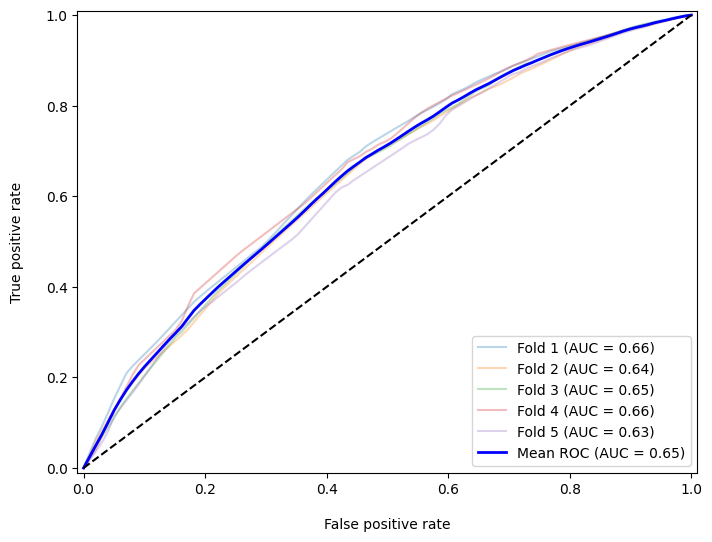

In [6]:
auc_scores, tprs, mean_fpr = k_fold_AUC_BN(model_data)

We see that the mean AUC is 0.65, and that the variance among folds is very low.

### **3.2 Precision-Recall**

This is a measure of prediction success when there is imbalance in the classes. In our cases, the classes are either 0 (no captures) or 1 (at least one prey capture).

**Precision** is a measure of result relevancy, that is, how many of the positive predictions are correct (true positives). It can be written as : 

$
N. \ positive \ predictions = true \ positives + false \ positives
$

$
precision = \frac{N. \ correct \ predictions}{N. \ of \ positive \ predictions}
$

**Recall** is a measure of how many truly relevant results are returned. It indicates how many of the positive cases were correctly predicted. It is also referred to as *sensitivity*.

$
N. \ total \ positive \ instances = true \ positives + false \ negatives
$

$
recall = \frac{N. \ correct \ predictions}{N. \ total \ positive \ instances}
$

In [7]:
def k_fold_PrecRec_BN(model_data, n_splits = 5, random_state = 123):
    # Shuffle the predator IDs
    ids = model_data["predator_id"].unique()
    np.random.seed(random_state)
    np.random.shuffle(ids)

    # Split the IDs into equal parts across folds
    fold_size = len(ids) // n_splits
    fold_indices = [
        list(ids[i * fold_size:(i + 1) * fold_size]) for i in range(n_splits)
    ]

    # Initialize KFold with shuffle = True to shuffle the indices
    kf = KFold(
        n_splits = n_splits,
        shuffle = True,
        random_state = random_state
    )

    # Create empty objects that will be appended to
    pr_auc_scores = []
    mean_recall = np.linspace(0, 1, 100)
    precisions = []

    plt.figure(figsize=(8, 6))

    for fold, (train_idx, test_idx) in enumerate(kf.split(fold_indices)):

        train_predator_ids = [
            predator_id for sublist in [fold_indices[i] for i in train_idx] for predator_id in sublist
        ]

        test_predator_ids = [
            predator_id for sublist in [fold_indices[i] for i in test_idx] for predator_id in sublist
        ]

        # Create the training and testing sets
        train_data = model_data[model_data["predator_id"].isin(train_predator_ids)].copy()
        test_data = model_data[model_data["predator_id"].isin(test_predator_ids)].copy()

        # Remove rows with missing values
        train_data = train_data.dropna()
        test_data = test_data.dropna()

        # Define the Bayesian Network structure
        model = BayesianNetwork([
            # Edges for hunting type
            # Previous experience
            ("prior_chases_persec_bin", "pred_speed_bin"),
            ("prior_prey_captured", "pred_speed_bin"),
            ("prior_prey_speed_bin", "pred_speed_bin"),
            ("iqrange_prey_speed_bin", "pred_speed_bin"),
            # Expertise
            ("xp_level", "pred_speed_bin"),
            ("time_lag_session_log_bin", "pred_speed_bin"),
            # Direct interaction
            ("prey_var_speed_log_bin", "pred_speed_bin"),

            # Edges for chase rate
            # Expertise
            ("xp_level", "chases_persec_bin"),
            ("time_lag_session_log_bin", "chases_persec_bin"),
            # Predator strategy
            ("pred_speed_bin", "chases_persec_bin"),
            # Direct interaction
            ("prey_avg_speed_bin", "chases_persec_bin"),
            ("prey_var_speed_log_bin", "chases_persec_bin"),

            # Edges for prey speed
            ("pred_speed_bin", "prey_avg_speed_bin"),

            # Edges for prey captured
            ("pred_speed_bin", "prey_captured"),
            ("chases_persec_bin", "prey_captured"),
            ("prey_avg_rank_bin", "prey_captured")
        ])

        # Extract true labels
        true_labels = test_data["prey_captured"]
        true_labels = true_labels.values

        # Remove predator_id from the train data
        train_data = train_data.drop(columns = ["predator_id"])
        # Remove predator_id and prey_captured from the test data
        # I remove prey_captured because
        # it's the variable I want to predict
        test_data = test_data.drop(columns = [
            "predator_id", "prey_captured"
        ])

        # Fit the model to each training fold
        model.fit(
            data = train_data,
            estimator = BayesianEstimator,
            prior_type = "BDeu",
            equivalent_sample_size = 5
        )

        # Calculate predictions for each testing fold
        pred_probs = model.predict_probability(data = test_data)

        # Predicted probabilities for prey_captured = 1
        pred_probs = pred_probs.values  # As an array
        pred_probs = pred_probs[:, 1]  # Extract for = 1

        # Calculate precision-recall curve for each fold
        precision, recall, _ = precision_recall_curve(true_labels, pred_probs)
        pr_auc = auc(recall, precision)
        pr_auc_scores.append(pr_auc)

        # Interpolate the recall to create a smooth curve
        mean_recall = np.linspace(0, 1, 100)
        precisions.append(np.interp(mean_recall, recall[::-1], precision[::-1]))

        # Plot precision-recall curve for each fold
        plt.plot(
            recall, precision,
            label = f"Fold {fold + 1} (AUC-PR = {pr_auc:.2f})",
            alpha = 0.3
        )

    # Calculate mean precision across folds
    mean_pr_auc = np.mean(pr_auc_scores)
    mean_precision = np.mean(precisions, axis = 0)
    # This forces the precision to 0 when recall = 1
    #mean_precision[-1] = 0.0

    # Plot mean precision-recall curve
    plt.plot(
        mean_recall, mean_precision,
        color = "b",
        lw = 2,
        label = f"Mean Precision-Recall (AUC-PR = {mean_pr_auc:.2f})"
    )

    # Plot parameters
    plt.xlabel("\nRecall")
    plt.ylabel("Precision\n")
    plt.legend(loc = "lower left")
    plt.xlim(-0.01, 1.01)
    plt.ylim(-0.01, 1.01)
    plt.show()

    return pr_auc_scores, precisions, mean_recall

Call the function and plot the results

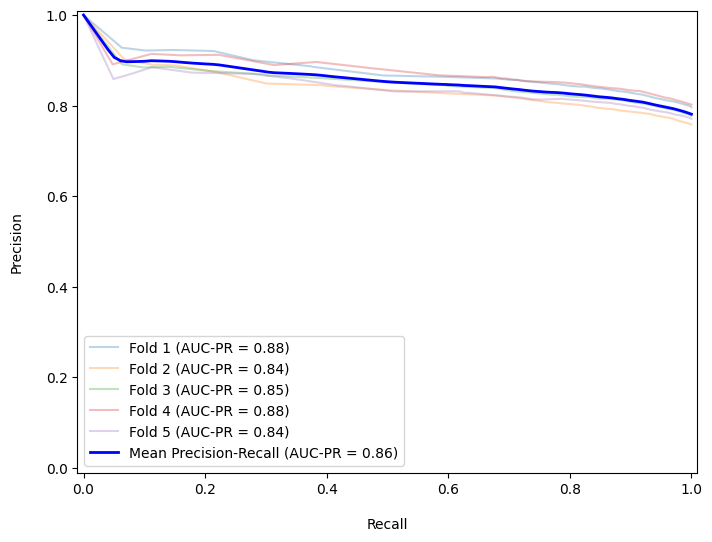

In [8]:
pr_auc_scores, precisions, mean_recall = k_fold_PrecRec_BN(model_data)

As we can see, the model is quite good at predicting true positives even at higher recall values. The mean precision-recall across k-folds is 0.86.

---